In [15]:
import pandas as pd

df = pd.read_csv('movies_with_genres.csv')

keep_columns = [
    'Title', 'Year', 'Revenue (Millions)', 'Similar_Movies'
]

df_clean = df[keep_columns].copy()

In [16]:
df_clean['Similar_Movies'] = df_clean['Similar_Movies'].apply(eval)

similar_pairs = []
for idx, row in df_clean.iterrows():
    for similar_title in row['Similar_Movies']:
        similar_pairs.append({
            'Title_1': row['Title'],
            'Title_2': similar_title,
            'Year_1': row['Year'],
            'Year_2': df_clean[df_clean['Title'] == similar_title]['Year'].values[0],
            'Revenue_1': row['Revenue (Millions)'],
            'Revenue_2': df_clean[df_clean['Title'] == similar_title]['Revenue (Millions)'].values[0],
            'Group': 'A'  
        })

df_similar = pd.DataFrame(similar_pairs)

In [17]:
import random

dissimilar_pairs = []
titles = df_clean['Title'].tolist()

for _ in range(len(df_similar)): 
    title1, title2 = random.sample(titles, 2)
    dissimilar_pairs.append({
        'Title_1': title1,
        'Title_2': title2,
        'Year_1': df_clean[df_clean['Title'] == title1]['Year'].values[0],
        'Year_2': df_clean[df_clean['Title'] == title2]['Year'].values[0],
        'Revenue_1': df_clean[df_clean['Title'] == title1]['Revenue (Millions)'].values[0],
        'Revenue_2': df_clean[df_clean['Title'] == title2]['Revenue (Millions)'].values[0],
        'Group': 'B'  
    })

df_dissimilar = pd.DataFrame(dissimilar_pairs)

In [18]:
df_pairs = pd.concat([df_similar, df_dissimilar], ignore_index=True)

In [19]:
df_pairs['Year_Diff'] = abs(df_pairs['Year_1'] - df_pairs['Year_2'])
df_pairs = df_pairs[df_pairs['Year_Diff'] <= 2]  

In [20]:
df_pairs['Revenue_Diff'] = abs(df_pairs['Revenue_1'] - df_pairs['Revenue_2'])

In [21]:
df_pairs

,Title_1,Title_2,Year_1,Year_2,Revenue_1,Revenue_2,Group,Year_Diff,Revenue_Diff
0,Guardians of the Galaxy,Suicide Squad,2014,2016,333.13,325.02,A,2,8.11
1,Guardians of the Galaxy,Interstellar,2014,2014,333.13,187.99,A,0,145.14
2,Guardians of the Galaxy,Star Wars: Episode VII - The Force Awakens,2014,2015,333.13,936.63,A,1,603.50
4,Guardians of the Galaxy,Hardcore Henry,2014,2015,333.13,9.24,A,1,323.89
5,Guardians of the Galaxy,Battleship,2014,2012,333.13,65.17,A,2,267.96
...,...,...,...,...,...,...,...,...,...
6857,Miracles from Heaven,The Lost City of Z,2016,2016,61.69,8.01,B,0,53.68
6858,Rock Dog,Brimstone,2016,2016,9.40,NaN,B,0,NaN
6860,Wreck-It Ralph,Clown,2012,2014,189.41,0.05,B,2,189.36
6861,Allied,Lovesong,2016,2016,40.07,0.01,B,0,40.06


In [22]:
import pandas as pd
from scipy import stats

group_A = df_pairs[df_pairs['Group'] == 'A']['Revenue_Diff']
group_B = df_pairs[df_pairs['Group'] == 'B']['Revenue_Diff']

In [23]:
group_A_clean = group_A.dropna()
group_B_clean = group_B.dropna()

print("Cleaned Group A size:", len(group_A_clean))  
print("Cleaned Group B size:", len(group_B_clean))  

Cleaned Group A size: 1242
Cleaned Group B size: 1165


In [24]:
_, p_A = stats.shapiro(group_A_clean)
_, p_B = stats.shapiro(group_B_clean)

print(f"Group A normality p-value: {p_A:.4f}")
print(f"Group B normality p-value: {p_B:.4f}")


Group A normality p-value: 0.0000
Group B normality p-value: 0.0000


Not normal distribution, cannot use t-test, using Mann-Whitney U instead.

In [ ]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(group_A_clean, group_B_clean, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: Similar movies have significantly different revenue differences.")
else:
    print("Fail to reject H₀: No significant revenue difference between groups.")


Mann-Whitney U statistic: 668026.0000, p-value: 0.0011
Reject H₀: Similar movies have significantly different revenue differences.


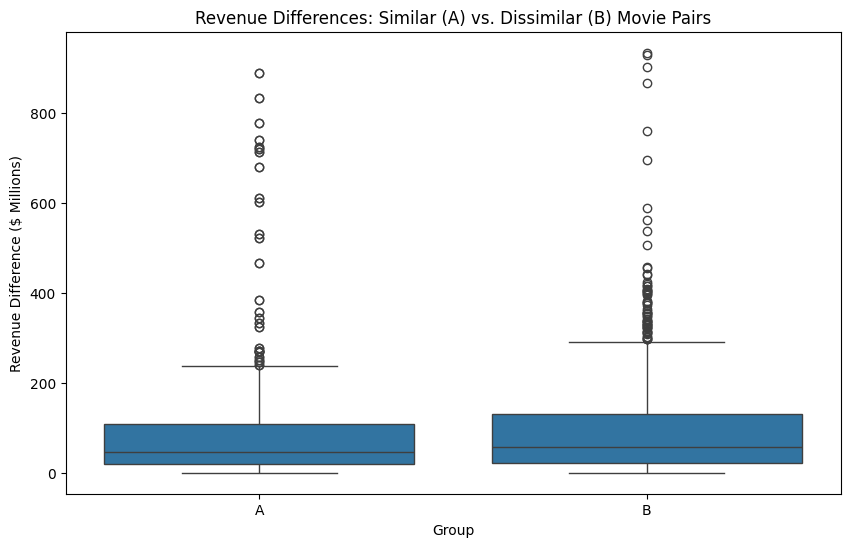

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Revenue_Diff', data=df_pairs.dropna())
plt.title("Revenue Differences: Similar (A) vs. Dissimilar (B) Movie Pairs")
plt.ylabel("Revenue Difference ($ Millions)")
plt.show()